In [6]:
from rich.pretty import pprint
from typing import List, Dict, Any, Optional

## Playbook: What is Softmax and Derivatives

WIKIPEDIA

---

The softmax function takes as input a vector $z$ of $K$ real numbers, and
normalizes it into a probability distribution consisting of $K$ probabilities
proportional to the exponentials of the input numbers. That is, prior to
applying softmax, some vector components could be negative, or greater than one;
and might not sum to 1 ; but after applying softmax, each component will be in
the interval $(0,1)$, and the components will add up to 1 , so that they can be
interpreted as probabilities. Furthermore, the larger input components will
correspond to larger probabilities.

For a vector $z$ of $K$ real numbers, the standard (unit) softmax function
$\sigma: \mathbb{R}^K \mapsto(0,1)^K$, where $K \geq 1$, is defined by the
formula

$$
\sigma(\mathbf{z})_i=\frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \text { for } i=1, \ldots, K \text { and } \mathbf{z}=\left(z_1, \ldots, z_K\right) \in \mathbb{R}^K
$$

In words, the softmax applies the standard exponential function to each element
$z_i$ of the input vector $\mathbf{z}$ and normalizes these values by dividing
by the sum of all these exponentials. The normalization ensures that the sum of
the components of the output vector $\sigma(\mathbf{z})$ is 1 . The term
"softmax" derives from the amplifying effects of the exponential on any maxima
in the input vector. For example, the standard softmax of $(1,2,8)$ is
approximately $(0.001,0.002,0.997)$, which amounts to assigning almost all of
the total unit weight in the result to the position of the vector's maximal
element (of 8 ).

In general, instead of $e$ a different base $\mathrm{b}>0$ can be used. If
$0<\mathrm{b}<1$, smaller input components will result in larger output
probabilities, and decreasing the value of $b$ will create probability
distributions that are more concentrated around the positions of the smallest
input values. Conversely, as above, if $b>1$ larger input components will result
in larger output probabilities, and increasing the value of $b$ will create
probability distributions that are more concentrated around the positions of the
largest input values. Writing $b=e^\beta$ or $b=e^{-\beta[\mathrm{a}]}$ (for
real $\left.\beta\right)^{[\mathrm{b}]}$ yields the expressions:[c]

$$
\sigma(\mathbf{z})_i=\frac{e^{\beta z_i}}{\sum_{j=1}^K e^{\beta z_j}} \text { or } \sigma(\mathbf{z})_i=\frac{e^{-\beta z_i}}{\sum_{j=1}^K e^{-\beta z_j}} \text { for } i=1, \ldots, K
$$

The reciprocal of $\beta$ is sometimes referred to as the temperature,
$T=1 / \beta$, with $b=e^{1 / T}$. A higher temperature results in a more
uniform output distribution (i.e. with higher entropy, and "more random"), while
a lower temperature results in a sharper output distribution, with one value
dominating.

In some fields, the base is fixed, corresponding to a fixed scale,
${ }^{[\mathrm{d}]}$ while in others the parameter $\beta$ is varied.

---

In [12]:
from torch import nn
import torch
import torch.nn.functional as F

class Softmax:
    """
    Softmax activation function.
    """

    def __call__(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the softmax function for a given input.
        """
        numerator = torch.exp(z)
        denominator = torch.sum(numerator, dim=1, keepdim=True)
        g = numerator / denominator
        return g

    def gradient(self, z: torch.Tensor) -> torch.Tensor:
        """
        Compute the derivative of the softmax function with respect to its input.
        """
        g = self.__call__(z)
        g = g.unsqueeze(-1)  # add an extra dimension
        eye = torch.eye(g.shape[1], device=z.device)[None, :]  # identity matrix
        dg_dz = g * (eye - g)
        return dg_dz.sum(dim=1)


# Create a sample input tensor
z = torch.randn(5, 10)  # Batch size of 5, 10 features



# Compare the results
print("PyTorch Softmax Output:", pytorch_softmax_outputs)


PyTorch Softmax Output: tensor([[0.0393, 0.1047, 0.0203, 0.2252, 0.1916, 0.0316, 0.2273, 0.0504, 0.0689,
         0.0407],
        [0.0243, 0.1802, 0.0876, 0.0895, 0.0414, 0.2126, 0.0688, 0.1057, 0.0289,
         0.1609],
        [0.0810, 0.0504, 0.5742, 0.0125, 0.0262, 0.0354, 0.0215, 0.0781, 0.0460,
         0.0747],
        [0.0301, 0.0559, 0.1491, 0.0595, 0.0328, 0.0501, 0.0416, 0.0215, 0.5511,
         0.0084],
        [0.0897, 0.0261, 0.4708, 0.0324, 0.0238, 0.1313, 0.0585, 0.0703, 0.0391,
         0.0581]])


In [ ]:
z = torch.randn((2, 5), requires_grad=True)
pytorch_softmax = nn.Softmax(dim=1)
pytorch_softmax_outputs = pytorch_softmax(z)


In [13]:
# Create a sample input tensor

# Use PyTorch's softmax and calculate gradients with respect to z
output_torch = F.softmax(z, dim=1)
loss_torch = output_torch.log().mean()  # Example loss for gradient calculation
loss_torch.backward()

# Gradients obtained via PyTorch
gradients_torch = z.grad.data

# Reset gradients in z for custom gradient computation
z.grad = None

# Compute softmax using custom function and calculate custom gradients
softmax = Softmax()
output_custom = softmax(z)
# For custom gradient calculation, we need an illustrative "loss" since gradients are usually
# calculated in the context of some scalar output. Here, we mimic a simple operation as a stand-in for loss.
loss_custom = output_custom.log().mean()
loss_custom.backward()

# Assuming custom gradient computation inside the backward method of a custom autograd function,
# here we manually compute it for comparison, which isn't directly applicable as is.
# gradients_custom = softmax.gradient(z)  # This line was proposed, but doesn't fit directly into the autograd framework as is.

# Print both gradients for comparison
print("Gradients via PyTorch's autograd:")
print(gradients_torch)
print("\nManual gradient computation currently doesn't integrate directly with autograd; needs adjustment.")
# Print the manually computed gradients for educational purposes, if applicable
# print("\nCustom computed gradients (for illustration, not directly comparable):")
# print(gradients_custom)

Gradients via PyTorch's autograd:
tensor([[-0.0172,  0.0806,  0.0072, -0.0803,  0.0096],
        [ 0.0730,  0.0435, -0.0768, -0.0686,  0.0288]])

Manual gradient computation currently doesn't integrate directly with autograd; needs adjustment.


In [10]:
# get gradients of nn.Softmax

z.requires_grad = True
z.retain_grad()
pytorch_softmax_outputs = pytorch_softmax(z)
pytorch_softmax_outputs.sum().backward()
print("PyTorch Softmax Gradient:", z.grad)

PyTorch Softmax Gradient: tensor([[-4.3086e-08, -5.9735e-09, -1.9813e-08, -2.2872e-08, -3.0181e-09,
         -5.1731e-08, -3.5311e-08, -1.6718e-08, -3.0283e-08, -9.6135e-09],
        [ 2.3789e-09,  8.6295e-09,  1.4517e-09,  1.9518e-08,  5.1734e-09,
          1.1618e-09,  1.5833e-08,  3.6878e-08,  1.0539e-08,  1.7647e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]])


In [7]:
# Compute the softmax using the custom implementation and PyTorch's implementation
my_softmax = Softmax()
my_softmax_outputs = Softmax()(z)

print("Custom Softmax Output:", my_softmax_outputs)
print("Are the outputs close?", torch.allclose(my_softmax_outputs, pytorch_softmax_outputs))

Custom Softmax Output: tensor([[0.1807, 0.0251, 0.0831, 0.0959, 0.0127, 0.2170, 0.1481, 0.0701, 0.1270,
         0.0403],
        [0.0200, 0.0724, 0.0122, 0.1637, 0.0434, 0.0097, 0.1328, 0.3094, 0.0884,
         0.1480],
        [0.2308, 0.1091, 0.0899, 0.0602, 0.1257, 0.0426, 0.0202, 0.0306, 0.1937,
         0.0972],
        [0.0800, 0.0191, 0.0798, 0.0291, 0.0149, 0.0273, 0.2551, 0.0710, 0.0156,
         0.4081],
        [0.0312, 0.1400, 0.0057, 0.0685, 0.0484, 0.1182, 0.1219, 0.1737, 0.0918,
         0.2006]], grad_fn=<DivBackward0>)
Are the outputs close? True


In [8]:
my_softmax.gradient(z)

tensor([[ 0.0395, -0.1162, -0.0581, -0.0453, -0.1286,  0.0757,  0.0069, -0.0711,
         -0.0142, -0.1009],
        [-0.1577, -0.1052, -0.1655, -0.0139, -0.1342, -0.1679, -0.0448,  0.1317,
         -0.0892, -0.0296],
        [ 0.0880, -0.0337, -0.0529, -0.0826, -0.0171, -0.1002, -0.1225, -0.1121,
          0.0509, -0.0456],
        [-0.1719, -0.2328, -0.1720, -0.2228, -0.2369, -0.2246,  0.0033, -0.1809,
         -0.2363,  0.1562],
        [-0.1041,  0.0046, -0.1296, -0.0668, -0.0869, -0.0171, -0.0134,  0.0384,
         -0.0435,  0.0653]], grad_fn=<SumBackward1>)

## Sampling Generation

### Order Preservation in Softmax

The softmax function, defined as

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$$

converts a vector of real-valued logits $[z_1, z_2, \ldots, z_n]$ into a
probability distribution $[p_1, p_2, \ldots, p_n]$, where each $p_i$ represents
the probability of the $i$th class. The key properties of softmax include:

-   **Order Preservation**: The softmax function preserves the order of logits.
    If a logit $z_a$ is greater than $z_b$ before applying softmax, the
    resulting probability $p_a$ will also be greater than $p_b$. This means that
    the relative ranking of logits is maintained in the probability
    distribution.
-   **Normalization**: The output probabilities sum up to 1, making it a valid
    probability distribution.

### Sharpness of Softmax Distribution

When introducing temperature $T$ into the softmax function:

$$\text{softmax}_T(z_i) = \frac{e^{z_i / T}}{\sum_{j} e^{z_j / T}}$$

the temperature modifies the "sharpness" of the probability distribution without
altering the order of the probabilities:

-   **At high temperatures** ($T > 1$), the distribution becomes more uniform,
    but if $z_a > z_b$, then $\text{softmax}_T(z_a) > \text{softmax}_T(z_b)$
    still holds. The probabilities become closer to each other, making the
    choice more "random" or "equally likely" among options, but the ranking
    remains the same.

-   **At low temperatures** ($T < 1$), the distribution becomes sharper, with a
    more pronounced difference between the higher and lower probabilities,
    amplifying the differences in likelihood as determined by the logits. The
    probability of the largest logit increases towards 1, while others decrease
    towards 0. Yet, the order of logits is preserved—higher logits translate to
    higher probabilities.

### Multinomial

In multinomial (or probabilistic) sampling, the model samples from the entire
probability distribution obtained after applying softmax:

At higher temperatures, the probability distribution becomes more uniform,
increasing the likelihood of sampling less probable tokens, thereby introducing
more randomness or diversity into the selection process. At lower temperatures,
the distribution becomes sharper, concentrating most of the probability mass on
a few high-probability tokens. This makes the selection less random and more
predictable, closely aligning with the greedy selection outcome but still
allowing for some variability.

KEY is to understand multinomial in the sampling.

### Greedy vs Probabilistic sampling

If your model employs a greedy strategy for selecting tokens (e.g., always
choosing the token with the highest probability), then adjusting the temperature
won't change the selected token. This approach is common in tasks where
precision is critical, and the aim is to reduce randomness to a minimum, such as
in certain classification tasks or when generating text where maximum coherence
is desired.

In [10]:
import torch
from typing import List
from rich.pretty import pprint

In [3]:
def demonstrate_multinomial_sampling_effect(logits: torch.Tensor, temperatures: List[float], epsilon: float = 1e-8):
    """
    Demonstrates the effect of temperature on multinomial sampling from the softmax distribution.

    Args:
        logits (torch.Tensor): The input logits.
        temperatures (list): A list of temperatures to apply.
        num_samples (int): The number of samples to draw from the distribution.

    Returns:
        dict: A dictionary mapping each temperature to its corresponding sampled outcomes.
    """
    softmax_results = {}
    sampling_results = {}
    for temperature in temperatures:
        scaled_logits = logits / (temperature + epsilon)  # Scale logits by temperature
        probs = torch.softmax(scaled_logits, dim=-1)  # Apply softmax to scaled logits
        samples = torch.multinomial(probs, num_samples=1, replacement=False)
        softmax_results[temperature] = probs.numpy()
        sampling_results[temperature] = samples.numpy()
    return softmax_results, sampling_results

1 - preserve order show it in code
2 - sample more times to show effect - distribution count for each 

In [16]:
# Example logits
logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])

# Temperatures to explore
temperatures = [0.1, 1.0, 10.0]

# Generate samples under different temperatures
softmax_distributions, sampling_distributions = demonstrate_multinomial_sampling_effect(logits, temperatures)

pprint(softmax_distributions)
pprint(sampling_distributions)

{
│   0.1: array([1.9286696e-22, 4.2481610e-18, 9.3572157e-14, 2.0610600e-09,
│      4.5397868e-05, 9.9995458e-01], dtype=float32),
│   1.0: array([0.00426978, 0.01160646, 0.03154963, 0.08576079, 0.233122  ,
│      0.6336913 ], dtype=float32),
│   10.0: array([0.12792668, 0.14138085, 0.15624999, 0.17268294, 0.19084416,
│      0.21091543], dtype=float32)
}

{0.1: array([5]), 1.0: array([5]), 10.0: array([4])}

In [18]:
logits

tensor([1., 2., 3., 4., 5., 6.])

Here's how the softmax distribution changes with different temperatures for the
given logits `[1.0, 2.0, 3.0]`:

-   **Temperature = 0.1**: The softmax probabilities are approximately
    `[2.06e-09, 4.54e-05, 0.9999]`. At this low temperature, the distribution
    becomes extremely "sharp," where the highest logit (3.0) dominates, and its
    probability is almost 1. This demonstrates the effect of low temperatures in
    making the softmax output more deterministic, favoring the highest logit
    significantly over the others.

-   **Temperature = 1.0** (no scaling): The softmax probabilities are
    `[0.09, 0.24, 0.67]`. This is the standard softmax distribution without any
    temperature scaling. The highest logit still has the highest probability,
    but the distribution is less skewed than at lower temperatures, allowing for
    some level of variability in sampling.

-   **Temperature = 10.0**: The softmax probabilities are `[0.30, 0.33, 0.37]`.
    At this high temperature, the distribution becomes much "softer," and the
    probabilities are closer to each other, making the outcome more uniform.
    This indicates increased randomness in sampling, as the differences between
    the logits are dampened, making it less predictable which token will be
    sampled.

### Conclusion

-   **Low temperatures** sharpen the softmax distribution, increasing the
    probability of the highest logit significantly and making the model's output
    more predictable.

-   **High temperatures** soften the softmax distribution, equalizing the
    probabilities and introducing more randomness into the model's output.

This demonstrates the practical effect of temperature on the behavior of softmax
and, by extension, on the sampling strategy used in generative models.

To cater to a mathematical audience, let's delve deeper into the formal
definition of multinomial sampling and its connection to temperature-scaled
softmax distributions in the context of sequence generation models.

### Multinomial Distribution

The multinomial distribution is a generalization of the binomial distribution.
It models the probabilities of observing counts among multiple categories and is
parametrized by probabilities $\pi_1, \pi_2, \ldots, \pi_n$ corresponding to $n$
outcomes. These probabilities must satisfy two conditions:

1. $0 \leq \pi_i \leq 1$ for all $i$,
2. $\sum\_{i=1}^{n} \pi_i = 1$.

Given a single trial, the probability of outcome $i$ occurring is $\pi_i$. When
sampling from a multinomial distribution, each sample (or draw) is independent,
and the probability of observing a specific outcome follows the distribution
defined by $\pi$.

### Formalizing Multinomial Sampling

In the context of generative models, after computing the softmax distribution
over the logits (or scores) $z_i$ for each token $i$ in the vocabulary, the
softmax function at temperature $T$ is applied to obtain probabilities:

$$p*i = \frac{\exp(z_i / T)}{\sum*{j=1}^{n} \exp(z_j / T)}$$

Here, $p_i$ represents the probability of selecting token $i$ as the next token
in the sequence, forming a probability distribution
$\pi = [p_1, p_2,
\ldots, p_n]$ over the vocabulary.

Given $\pi$, multinomial sampling draws a sample $s$ where $P(s=i) = p_i$. This
process can be repeated to generate sequences of tokens.

### Impact of Temperature on Multinomial Sampling

The temperature parameter $T$ modulates the sharpness of the probability
distribution $\pi$:

-   **For $T < 1$**, the distribution becomes sharper, with a higher probability
    concentrated on the tokens with the highest logits. This makes the sampling
    process more deterministic, as the variance among the probabilities is
    increased, favoring the selection of the most likely token.

-   **For $T = 1$**, the distribution is exactly the softmax of the logits,
    representing the model's learned probabilities without modification.

-   **For $T > 1$**, the distribution becomes flatter, making less likely tokens
    more probable to be selected. This introduces more randomness into the
    sampling process, as the variance among the probabilities is decreased.

### Example in Sequence Generation

Consider generating text from a model trained on a large corpus. At each step,
the model outputs logits, which are transformed into probabilities $\pi$ using
the softmax function scaled by temperature $T$. Multinomial sampling is then
used to select the next token from these probabilities. Adjusting $T$ allows
controlling the randomness and diversity of the generated text: lower $T$ favors
more predictable text closely following the training data, while higher $T$
favors more novel and varied sequences.

This formal treatment of multinomial sampling and temperature's role offers a
nuanced understanding of how generative models like GPT navigate the trade-offs
between diversity and fidelity in sequence generation.


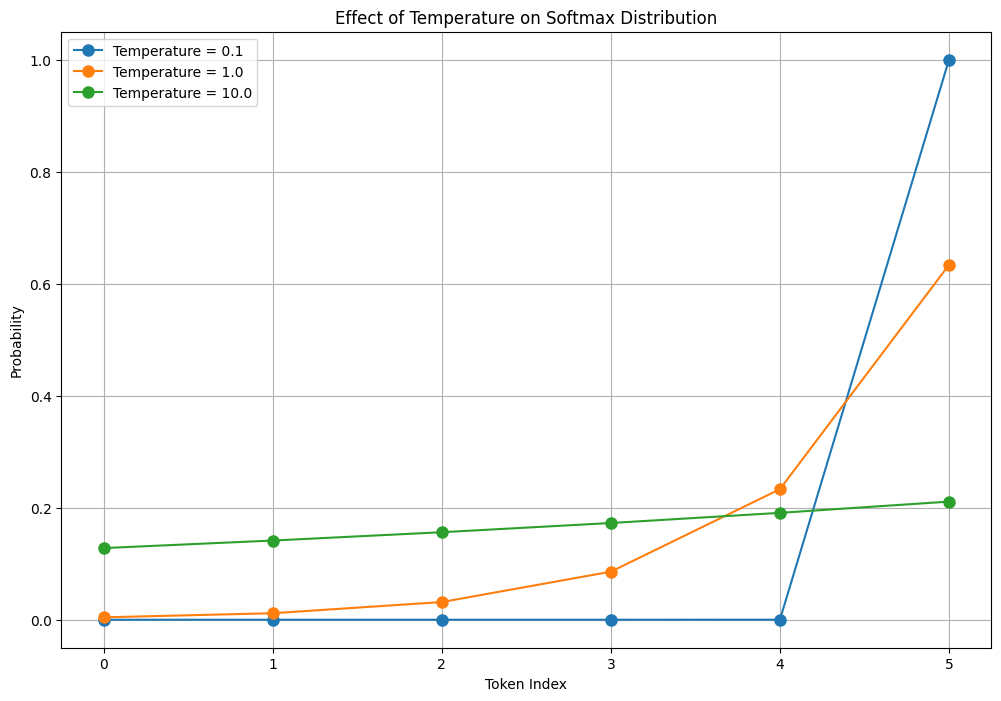

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(logits, temperature=1.0):
    """Compute softmax values for each set of logits in x."""
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))  # for numerical stability
    return exp_logits / np.sum(exp_logits)

plt.figure(figsize=(12, 8))

logits = logits.numpy()

for temp in temperatures:
    probs = softmax(logits, temperature=temp)
    plt.plot(probs, label=f'Temperature = {temp}', marker='o', linestyle='-', markersize=8)

plt.title('Effect of Temperature on Softmax Distribution')
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.xticks(range(len(logits)))
plt.legend()
plt.grid(True)
plt.show()


# Why Do We Like To Use Warmup and Cosine Schedulers?

Decays the learning rate according to the decreasing part of a cosine curve,
with an initial warmup.

The `CosineAnnealingWithWarmupScheduler` modulates the learning rate according
to a two-phase process: a warmup phase followed by a cosine annealing phase. The
learning rate _multiplier_ (this is a multiplier and not the real learning rate)
$\alpha_{t}$ at time (step) $t$ is given by:

$$
\begin{equation}
\alpha_{t} = \begin{cases}
    \frac{t}{t_{\text{warmup}}}, & \text{if } t < t_{\text{warmup}} \\
    \alpha_f + (1 - \alpha_f) \times \frac{1}{2} \left[1 + \cos(\tau_w\pi) \right], & \text{otherwise}
\end{cases}
\end{equation}
$$

where we denote:

-   $\tau_w = \frac{t - t_{\text{warmup}}}{t_{\max}}$, the fraction of
    post-warmup time elapsed,
    -   $t$ as the **current** training step,
    -   $t_{\text{warmup}}$ as the **warmup** time (in steps),
    -   $t_{\max}$ as the **maximum** number of training steps, or maximum
        number of iterations in an epoch (see
        [here](https://github.com/skorch-dev/skorch/issues/610)). Note that if
        you set it to the total number of training steps, the scheduler will
        only decay the learning rate after the warmup phase and not oscillate
        it.
-   $\alpha_f$ is a _scaling_ factor that determines the **final** learning rate
    multiplier to decay to (a value between $0$ and $1$), and this is a _fixed_
    value. For example, if $\alpha_f = 0.1$ and the initial learning rate is
    $\eta_{\max} = 3e-4$, then the final learning rate will be
    $\eta_{\min} = 3e-4 \times 0.1 = 3e-5$.

-   $\eta_{\max}$ as the **initial** learning rate and will be the **maximum**
    learning rate reached during training.

The actual learning rate $\eta_{t}$ at time (step) $t$ is then computed as:

$$
\begin{equation}
\eta_{t} = \alpha_{t} \times \eta_{\max}
\end{equation}
$$

where we emphasize again that $\eta_{\max}$ is the **initial** learning rate and
will be the **maximum** learning rate reached during training.

## Running Example

For simplicity, we assume that there are a total of $10$ training steps (or
epoches) depending on how you define it. Consequently, the $t_{\text{max}}$ is
$10$.

-   $\eta_{\max} = 3e-4$
-   $t_{\text{warmup}} = 5$
-   $t_{\max} = 10$
-   $\alpha_f = 0.5$

## 1. Warmup Phase

During the warmup phase, when the **current** training step $t$ is less than the
warmup time $t_{\text{warmup}}$, the learning rate multiplier is **linearly**
increased from $0$ to $1$.

Mathematically, the learning rate multiplier $\alpha_{t}$ at time (step) $t$ is

$$
\alpha_{t} = \frac{t}{t_{\text{warmup}}}
$$

The learning rate at this phase is:

$$
\begin{align*}
\eta_{t} &=  \alpha_{t} \times \eta_{\max} \\
&= \frac{t}{t_{\text{warmup}}} \times \eta_{\max}
\end{align*}
$$

### Example

During the warmup phase, the learning rate will linearly increase from $0$ to
$\eta_{\max}$ in the first $t_{\text{warmup}}$ steps. Since
$\eta_{\max} = 3 \times 10^{-4}$ and $t_{\text{warmup}} = 5$, the learning rate
will be increased as follows:

-   $t = 1$:
    $$
    \begin{align*}
    \alpha_1 &= \frac{t}{t_{\text{warmup}}} = \frac{1}{5} = 0.2 \\
    \eta_1 &= \alpha_1 \times \eta_{\max} = 0.2 \times 3 \times 10^{-4} = 6 \times 10^{-5}
    \end{align*}
    $$
-   $t = 2$:
    $$
    \begin{align*}
    \alpha_2 &= \frac{t}{t_{\text{warmup}}} = \frac{2}{5} = 0.4 \\
    \eta_2 &= \alpha_2 \times \eta_{\max} = 0.4 \times 3 \times 10^{-4} = 1.2 \times 10^{-4}
    \end{align*}
    $$
-   $t = 3$:
    $$
    \begin{align*}
    \alpha_3 &= \frac{t}{t_{\text{warmup}}} = \frac{3}{5} = 0.6 \\
    \eta_3 &= \alpha_3 \times \eta_{\max} = 0.6 \times 3 \times 10^{-4} = 1.8 \times 10^{-4}
    \end{align*}
    $$
-   $t = 4$:
    $$
    \begin{align*}
    \alpha_4 &= \frac{t}{t_{\text{warmup}}} = \frac{4}{5} = 0.8 \\
    \eta_4 &= \alpha_4 \times \eta_{\max} = 0.8 \times 3 \times 10^{-4} = 2.4 \times 10^{-4}
    \end{align*}
    $$
-   $t = 5$:
    $$
    \begin{align*}
    \alpha_5 &= \frac{t}{t_{\text{warmup}}} = \frac{5}{5} = 1 \\
    \eta_5 &= \alpha_5 \times \eta_{\max} = 3 \times 10^{-4} \times 1 = 3 \times 10^{-4}
    \end{align*}
    $$

The linear relationship for the warmup phase can be represented as a function of
the current training step $x$:

$$
f(t) = \frac{t}{t_{\text{warmup}}}
$$

where $t_{\text{warmup}}$is the total number of steps in the warmup phase. This
function describes how the learning rate multiplier $\alpha_t$ grows linearly
from $0$ to $1$ as $t$ progresses from $0$ to $t_{\text{warmup}}$.

### Intuition

The warmup phase in learning rate scheduling, where the learning rate linearly
increases from a small value to a larger value, has its own unique intuition and
benefits. Here's an exploration of the underlying reasoning:

#### Practical Intuition

1. **Gentle Start**: Starting the training with a small learning rate allows the
   model to make small adjustments initially. This can be beneficial if the
   initial parameters are far from optimal, as it reduces the risk of
   overshooting or diverging.

2. **Adaptation to Data**: The gradual increase in learning rate allows the
   model to adapt to the data distribution and the structure of the loss
   landscape. This can be particularly valuable when training deep models, where
   the loss surface can be complex and non-convex.

3. **Acceleration of Convergence**: By gradually increasing the learning rate,
   the warmup phase can accelerate convergence by guiding the optimizer towards
   a good region of the loss landscape. Once the learning rate reaches its
   maximum value, the optimizer can take larger steps to explore this region.

4. **Compatibility with Adaptive Methods**: When used with adaptive optimization
   methods like Adam, the warmup phase can help stabilize the moving averages of
   gradients and squared gradients, leading to more robust optimization.

5. **Preventing Poor Local Minima**: By gradually increasing the learning rate,
   the optimizer may escape shallow or poor local minima in the early stages of
   training, enabling it to find a better solution.

#### Summary

The warmup phase in learning rate scheduling serves as a controlled and gradual
start to the training process. By linearly increasing the learning rate, it
helps the model adapt to the data, avoids potential pitfalls in the loss
landscape, and sets the stage for efficient optimization. The mathematical
formulation is simple, but it embodies a thoughtful approach to training
dynamics, often leading to improved convergence and generalization.

## 2. Cosine Decay Phase

After the warmup phase, the learning rate multiplier follows a cosine decay
pattern. This phase commences once the current training step $t$ is greater than
or equal to the warmup time $t_{\text{warmup}}$, and it continues until the
maximum training step $t_{\text{max}}$.

### 2.1. Tau Fraction

We first define a variable $\tau_w$ to represent the fraction of post-warmup
time elapsed. Mathematically, it is defined as:

$$
\tau_w = \frac{t - t_{\text{warmup}}}{t_{\text{max}}}
$$

where:

-   $t$: Current training step.
-   $t_{\text{warmup}}$: Warmup time in training steps.
-   $t_{\text{max}}$: Total duration of the scheduler in training steps.

### 2.2. Learning Rate Multiplier

The learning rate multiplier $\alpha_t$ during the cosine decay phase is given
by:

$$
\alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)  \left(1 + \cos \left(\tau_w\pi\right)\right)
$$

where $\alpha_f$ is the scaling factor that determines the final learning rate
multiplier to decay to.

### 2.3. Learning Rate

The actual learning rate $\eta_t$ during this phase is then computed as:

$$
\eta_{t} = \alpha_{t} \times \eta_{\text{max}}
$$

### Example

Using the running example with:

-   $\eta_{\text{max}} = 3 \times 10^{-4}$
-   $t_{\text{warmup}} = 5$
-   $t_{\text{max}} = 10$
-   $\alpha_f = 0.5$

The learning rate will be computed as follows:

-   $t = 6$:
    $$
    \begin{align*}
    \tau_w &= \frac{6 - 5}{10} = 0.1 \\
    \alpha_6 &= 0.5 + \frac{1}{2}(1 - 0.5) \left(1 + \cos \left(0.1\pi\right)\right) = 0.975445 \\
    \eta_6 &= 3 \times 10^{-4} \times 0.975445 = 2.92634 \times 10^{-4}
    \end{align*}
    $$
-   $t = 7$:
    $$
    \begin{align*}
    \tau_w &= \frac{7 - 5}{10} = 0.2 \\
    \alpha_7 &= 0.5 + \frac{1}{2}(1 - 0.5) \left(1 + \cos \left(0.2\pi\right)\right) = 0.904508 \\
    \eta_7 &= 3 \times 10^{-4} \times 0.904508 = 2.71352 \times 10^{-4}
    \end{align*}
    $$
-   ... (and so on for the remaining steps)

### Intuition

The cosine decay phase in the learning rate scheduler is designed to gradually
reduce the learning rate according to the cosine function. The intuition behind
this decay can be understood both mathematically and from a practical
standpoint.

#### Mathematical Intuition

1. **Cosine Function**: The cosine function oscillates between -1 and 1. By
   taking a scaled and shifted version of the cosine function, we can create a
   curve that starts at its highest point and gradually descends to its lowest
   point over the interval $[0, t_{\text{max}}]$.

2. **Decay Formula**: The formula for the learning rate multiplier during the
   decay phase is:

    $$
    \alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)\left(1 + \cos \left(\tau_w\pi\right)\right)
    $$

    Here, $\tau_w$ is the fraction of time elapsed since the warmup phase, and
    it ranges from 0 to 1. The $\cos(\tau_w\pi)$ term creates a curve that
    starts at 1 (when $\tau_w = 0$) and ends at -1 (when $\tau_w = 1$). The
    scaling and shifting ensure that $\alpha_t$ starts at 1 and decays to
    $\alpha_f$.

More concretely, the expression

$$
\alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)\left(1 + \cos \left(\tau_w\pi\right)\right)
$$

describes the learning rate multiplier during the decay phase, where $\tau_w$ is
the fraction of time elapsed since the warmup phase where $\tau_w$ is the
fraction of time elapsed since the warmup phase, and it ranges from 0 to 1.

Let's zoom into the cosine decay part in more details:

-   The term $\cos(\tau_w\pi)$ oscillates between 1 and -1 as $\tau_w$ varies
    from 0 to 1.
-   When you add 1 to this term, the expression $1 + \cos(\tau_w\pi)$ oscillates
    between 0 and 2.
-   Multiplying this by $\frac{1}{2}$ scales it down, so the expression
    $\frac{1}{2}\left(1 + \cos(\tau_w\pi)\right)$ oscillates between 0 and 1.
-   The term $\frac{1}{2}(1 - \alpha_f)$ scales this oscillation so that the
    amplitude is adjusted based on the desired final learning rate multiplier
    $\alpha_f$. This means if $\alpha_f = 0.5$, the expression
    $\frac{1}{2}(1 - \alpha_f)\left(1 + \cos(\tau_w\pi)\right)$ oscillates
    between 0 and 0.5.
-   Adding $\alpha_f$ shifts the entire expression so that it starts at 1 when
    $\tau_w = 0$ and decays to $\alpha_f$ when $\tau_w = 1$.

The addition of $\alpha_f$ in the decay formula serves the purpose of setting
the final value of the learning rate multiplier $\alpha_t$ to $\alpha_f$ at the
end of training. Let's break down the equation step by step to understand why
$\alpha_f$ is added back.

Given the formula:

$$
\alpha_{t} = \alpha_f + \frac{1}{2}(1 - \alpha_f)\left(1 + \cos \left(\tau_w\pi\right)\right)
$$

First, consider the case where $\tau_w = 0$ (i.e., the beginning of the decay
phase):

-   The cosine term becomes $\cos(0) = 1$.
-   The entire expression inside the parentheses becomes $1 + 1 = 2$.
-   The scaling factor $\frac{1}{2}(1 - \alpha_f)$ then multiplies this by
    $\frac{1 - \alpha_f}{2}$.
-   So the expression becomes
    $\alpha_f + \frac{1 - \alpha_f}{2} \times 2 = \alpha_f + (1 - \alpha_f) = 1$.

So at $\tau_w = 0$, $\alpha_t$ starts at 1.

Now consider the case where $\tau_w = 1$ (i.e., the end of training):

-   The cosine term becomes $\cos(\pi) = -1$.
-   The entire expression inside the parentheses becomes $1 - 1 = 0$.
-   The scaling factor then multiplies this by
    $\frac{1 - \alpha_f}{2}\times 0 = 0$.
-   So the expression becomes $\alpha_f + 0 = \alpha_f$.

So at $\tau_w = 1$, $\alpha_t$ decays to $\alpha_f$.

By adding $\alpha_f$, you ensure that the learning rate multiplier starts at 1
and smoothly decays to the desired final value $\alpha_f$. Without adding
$\alpha_f$, the expression would start at 1 but decay to 0, rather than the
intended final value. The addition of $\alpha_f$ shifts the entire decay curve
so that it aligns with the desired starting and ending values.

#### Practical Intuition

1. **Gradual Reduction**: The cosine decay provides a smooth and gradual
   reduction in the learning rate. Unlike a step decay, where the learning rate
   suddenly drops at specific intervals, the cosine decay reduces the learning
   rate in a more continuous manner.

2. **Avoiding Local Minima**: The smooth decay helps the optimization process
   explore the loss landscape more thoroughly. It can avoid getting stuck in
   local minima in the early stages of training by keeping the learning rate
   relatively high. Then, as training progresses, the learning rate decreases,
   allowing the optimizer to converge to a local minimum.

3. **Flexibility**: By controlling parameters like $\alpha_f$ (final learning
   rate multiplier) and $t_{\text{max}}$ (total duration of the scheduler), you
   can fine-tune the decay behavior to suit your specific training scenario.

#### Summary

The cosine decay in the learning rate scheduler is designed to balance
exploration and exploitation in the optimization process. It starts with a
relatively high learning rate to explore the loss landscape and then gradually
reduces it to allow for fine-tuning and convergence. The mathematical
formulation is inspired by the properties of the cosine function, providing a
smooth and controlled decay that can be tailored to different training needs.

## PyTorch's CosAnnealingLR

In PyTorch's
[CosAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR),
they implemented the cosine annealing scheduler without warmup, but the base
formula should be similar. Let's take a look to see how they coincide.

1. PyTorch’s `CosineAnnealing` without warmup:
   <https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR>
2. Composers `CosineAnnealing` without warmup:
   <https://docs.mosaicml.com/projects/composer/en/stable/api_reference/generated/composer.optim.CosineAnnealingScheduler.html#composer.optim.CosineAnnealingScheduler>

The formula looks a bit different at first glance (without loss of generality,
we can ignore warmup here), after digging a bit deeper, I tried to establish the
equivalence by setting `eta_min` of pytorch to `alpha_f x eta_max`,

$$
\begin{equation}
\eta_{t} = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right)
\end{equation}
$$

where there is a new notation $\eta_{\min}$, which is the minimum learning rate.
Furthermore, they do not have the $\alpha_f$ term, which is the scaling factor
that determines the final learning rate multiplier to decay to.

To prove their equivalence, set $\eta_{\min} = \alpha_f \times \eta_{\max}$, and

$$
\begin{align*}
\eta_{t} & = \eta_{\min} + \frac{1}{2}(\eta_{\max} - \eta_{\min})\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right) \\
         & = \underbrace{\alpha_f \times \eta_{\max}}_{\eta_{\min}} + \frac{1}{2}\left(\eta_{\max} - \underbrace{\alpha_f \times \eta_{\max}}_{\eta_{\min}}\right)\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right) \\
         & = \alpha_f \times \eta_{\max} + \frac{1}{2}\left(1 - \alpha_f\right) \eta_{\max}\left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right) \\
         & = \eta_{\max} \left(\alpha_f + \frac{1}{2}\left(1 - \alpha_f\right) \left(1 + \cos\left(\frac{t}{t_{\max}}\pi\right)\right)\right) \\
         & = \eta_{\max} \underbrace{\left(\alpha_f + \frac{1}{2}(1 - \alpha_f)  \left(1 + \cos \left(\tau_w\pi\right)\right)\right)}_{\alpha_t} \\
         & = \alpha_t \times \eta_{\max}
\end{align*}
$$

Setting $\eta_{\min} = \alpha_f \times \eta_{\max}$ is also not an arbitrary
choice. If we interpret $\eta_{\min}$ as the minimum learning rate, then it
makes sense to set it to $\alpha_f \times \eta_{\max}$, since $\alpha_f$ is the
scaling factor that determines the final learning rate multiplier to decay to
from $\eta_{\max}$. More concretely, if the initial learning rate
$\eta_{\max} = 3e-4$ and $\alpha_f = 0.1$, then the final learning rate will be
$\eta_{\min} = 3e-4 \times 0.1 = 3e-5$.

## Implementation

Now, let's write code to plot the graph of this scheduler, showing how the
learning rate multiplier changes over the training steps.

```python
import argparse
import math
from typing import Union, List, Optional

import matplotlib.pyplot as plt
import numpy as np


# Function for the learning rate scheduler
def cosine_annealing_with_warmup(
    t: int, t_warmup: Union[int, float], t_max: Union[int, float], alpha_f: float
) -> float:
    """Computes the learning rate multiplier using cosine annealing with warmup.

    Args:
        t (int): Current training step.
        t_warmup (int or float): Warmup time in training steps.
        t_max (int or float): Total duration of the scheduler in training steps.
        alpha_f (float): Learning rate multiplier to decay to.

    Returns:
        alpha (float): The learning rate multiplier at the given training step.
    """
    if t < t_warmup:
        alpha = t / t_warmup
    else:
        tau_w = (t - t_warmup) / t_max
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha


def plot_scheduler(
    steps: np.ndarray,
    lr_values: List[float],
    t: int,
    lr_at_t: Optional[float] = None,
    save: bool = False,
) -> None:
    plt.figure(figsize=(10, 6))
    plt.plot(steps, lr_values, label="Cosine Annealing with Warmup")
    plt.xlabel("Training Steps")
    plt.ylabel("Learning Rate")
    plt.title("Cosine Annealing with Warmup Scheduler")
    plt.legend()
    plt.grid(True)
    if t is not None:
        # Draw the red vertical line at the specified step t, with annotation
        plt.axvline(x=t, color="r", linestyle="--", label=f"Step {t}")
    if lr_at_t is not None:
        plt.annotate(
            f"Step {t}, LR: {lr_at_t}",
            (t, lr_at_t),
            xytext=(5, 5),
            textcoords="offset points",
            color="r",
        )
    if save:
        plt.savefig("cosine_annealing_with_warmup.png")
    plt.show()


def main() -> None:
    parser = argparse.ArgumentParser(
        description="Cosine Annealing with Warmup Learning Rate Scheduler"
    )

    parser.add_argument(
        "--t_warmup", type=int, default=100, help="Warmup time in training steps"
    )
    parser.add_argument(
        "--t_max",
        type=int,
        default=399998,
        help="Duration of the scheduler in training steps",
    )
    parser.add_argument(
        "--alpha_f",
        type=float,
        default=0.1,
        help="Learning rate multiplier to decay to",
    )
    parser.add_argument(
        "--eta_max", type=float, default=1.6e-4, help="Initial learning rate"
    )
    # optional argument
    parser.add_argument("--t", type=int, help="Training step to plot")
    parser.add_argument(
        "--save", action="store_true", help="Save the plot as a PNG file"
    )

    args = parser.parse_args()

    # Steps
    steps = np.arange(0, args.t_max + 1)

    # Learning rate values
    lr_values = [
        args.eta_max
        * cosine_annealing_with_warmup(t, args.t_warmup, args.t_max, args.alpha_f)
        for t in steps
    ]
    if args.t is not None:
        lr_at_t = lr_values[args.t]
        print(f"Learning rate at step {args.t}:", lr_at_t)
    else:
        lr_at_t = None

    # Call the plotting function
    plot_scheduler(steps, lr_values, args.t, lr_at_t, args.save)


if __name__ == "__main__":
    main()
    # 692431388224 0.0001589897227106072 21450
```

## Visualization

The plot visualizes the learning rate schedule defined by the
`CosineAnnealingWithWarmupScheduler`. Here's what the graph illustrates:

1. **Warmup Phase**: In the initial phase, the learning rate linearly increases
   from 0 to the initial learning rate $\eta\_{\max}$.

2. **Cosine Decay Phase**: After the warmup phase, the learning rate follows a
   cosine decay pattern, decreasing towards $\eta\_{\min}$.

## Summary

This combination of initial warmup followed by cosine decay is a common practice
in training neural networks. It allows the model to start learning slowly and
then follow a smooth decay, which often leads to better convergence. The
parameters $\eta*i$, $\alpha_f$, $t*{\text{warmup}}$, and $
t\_{\text{max}}$
provide flexibility in configuring the learning rate schedule according to the
specific needs of the training process.

## Intuition

Cosine annealing modifies the learning rate during training in a way that's
inspired by the shape of the cosine function. Initially, the learning rate is
set high, enabling rapid exploration of the parameter space. As training
progresses, the learning rate is gradually reduced following a cosine curve.
This helps the model to find more refined solutions by doing fine-tuning during
later stages of training.

The **intuition** behind cosine annealing involves two aspects:

1. **Exploration vs. Exploitation**: In the initial epochs, a high learning rate
   encourages exploring a broad region of the parameter space. As the learning
   rate decreases, the optimizer starts to exploit local minima, fine-tuning the
   weights.
2. **Avoiding Saddle Points and Local Minima**: The cosine annealing schedule
   also includes brief moments where the learning rate increases slightly, which
   can provide the necessary "nudge" to help the model escape non-optimal
   solutions.

## References and Further Readings

-   <https://d2l.ai/chapter_optimization/lr-scheduler.html#>


In [2]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW
from torch import nn
model = nn.Linear(10, 2)
optimizer = AdamW(model.parameters(), lr=0.1)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.01)
print(type(scheduler.get_lr()[0]))

<class 'float'>


/opt/homebrew/Caskroom/miniconda/base/envs/omniverse/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:809: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


In [3]:
from __future__ import annotations
import torch
import math
from typing import List

from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import LambdaLR
from functools import partial

def _get_cosine_schedule_with_warmup_lr_lambda(
    current_step: int, *, num_warmup_steps: int, num_training_steps: int, alpha_f: float
) -> float:
    """Cosine Annealing Warmup.
    t = current_step
    t_warmup = num_warmup_steps
    t_max = num_training_steps
    """

    if current_step < num_warmup_steps:
        alpha = current_step / max(1, num_warmup_steps)
    else:
        tau_w = (current_step - num_warmup_steps) / num_training_steps
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha

def get_cosine_annealing_with_warmup(
    optimizer: Optimizer, num_warmup_steps: int, num_training_steps: int, alpha_f: float = 0.1, last_epoch: int = -1, verbose: bool = False
) -> LambdaLR:
    """
    Create a schedule with a learning rate that decreases following the values of the cosine function between the
    initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
    initial lr set in the optimizer.

    Args:
        optimizer ([`~torch.optim.Optimizer`]):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (`int`):
            The number of steps for the warmup phase.
        num_training_steps (`int`):
            The total number of training steps.
        last_epoch (`int`, *optional*, defaults to -1):
            The index of the last epoch when resuming training.
        verbose (`bool`, *optional*, defaults to False):
            Whether to print the learning rate at every update.

    Return:
        `torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    lr_lambda = partial(
        _get_cosine_schedule_with_warmup_lr_lambda,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps,
        alpha_f=alpha_f,
    )
    return LambdaLR(optimizer, lr_lambda, last_epoch, verbose)

def cosine_annealing_with_warmup(t: int, t_warmup: float, t_max: float, alpha_f: float) -> float:
    """Computes the learning rate multiplier using cosine annealing with warmup.

    Parameters
    ----------
    t : int
        Current training step.
    t_warmup : float
        Warmup time in training steps.
    t_max : float
        Total duration of the scheduler in training steps.
    alpha_f : float
        Learning rate multiplier to decay to.

    Returns
    -------
    alpha : float
        The learning rate multiplier at the given training step.
    """
    if t < t_warmup:
        alpha = t / t_warmup
    else:
        tau_w = (t - t_warmup) / t_max
        tau_w = min(1.0, tau_w)
        alpha = alpha_f + (1 - alpha_f) * (1 + math.cos(math.pi * tau_w)) / 2
    return alpha


- refer to hf
- refer to mosaic so to highlight a bit diff in impleentations

In [32]:
from transformers import get_cosine_schedule_with_warmup

In [53]:

initial_lr = 0.1 # eta_max
t_warmup = 2
t_max = 10
alpha_f = 0.01
steps = np.arange(1, t_max + 1)

# Learning rate values
lr_values = [
    initial_lr
    * cosine_annealing_with_warmup(t, t_warmup, t_max, alpha_f)
    for t in steps
]
lr_values

[0.05,
 0.1,
 0.09757729755661011,
 0.09054634122155991,
 0.07959536998847742,
 0.0657963412215599,
 0.0505,
 0.03520365877844011,
 0.021404630011522586,
 0.010453658778440107]

In [54]:
optimizer = AdamW(model.parameters(), lr=initial_lr)

scheduler_1 = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)
# scheduler_1 = CosineAnnealingWarmupScheduler(optimizer, t_warmup=t_warmup, t_max=t_max, alpha_f=alpha_f)
lrs = []
for epoch in range(t_max + 1):
    optimizer.step()
    scheduler_1.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)

lrs

[0.05,
 0.1,
 0.09757729755661011,
 0.09054634122155991,
 0.07959536998847742,
 0.0657963412215599,
 0.0505,
 0.03520365877844011,
 0.021404630011522586,
 0.010453658778440107,
 0.0034227024433899004]

In [46]:
scheduler_hf = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=t_warmup, num_training_steps=t_max+t_warmup, num_cycles=0.5)

lrs_hf = []
for epoch in range(t_max + 1):
    optimizer.step()
    scheduler_hf.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs_hf.append(lr)

lrs_hf

[0.05,
 0.1,
 0.09797464868072488,
 0.09206267664155907,
 0.08274303669726427,
 0.07077075065009433,
 0.05711574191366427,
 0.04288425808633575,
 0.029229249349905687,
 0.017256963302735746,
 0.007937323358440935]

In [69]:
initial_lr

0.001

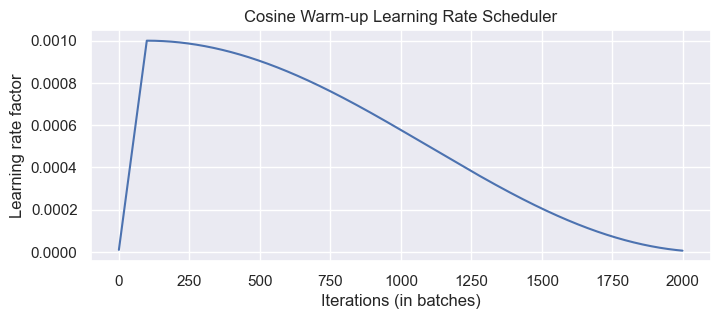

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

total_steps = 2000

initial_lr = 1e-3 # eta_max
t_warmup = 100
t_max = total_steps
alpha_f = 0
steps = np.arange(1, total_steps + 1)

p = nn.Parameter(torch.empty(4,4))
optimizer = AdamW([p], lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)

# Plotting
epochs = list(range(total_steps))
lrs = []
for epoch in epochs:
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)


sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, lrs)
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

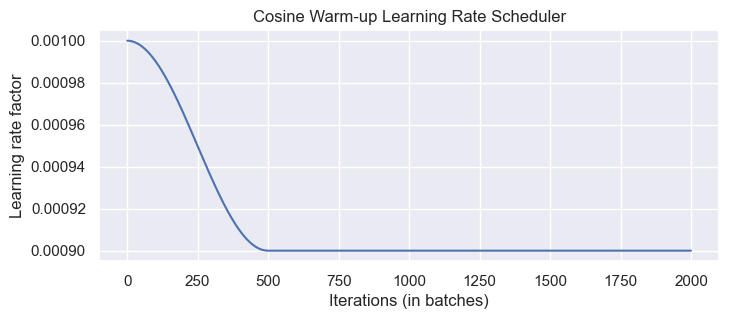

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

total_steps = 2000
initial_lr = 1e-3 # eta_max
t_warmup = 10

t_max = int(total_steps / 4) # oscillate 4 times
alpha_f = 0.9
steps = np.arange(1, total_steps + 1)

p = nn.Parameter(torch.empty(4,4))
optimizer = AdamW([p], lr=initial_lr)
scheduler = get_cosine_annealing_with_warmup(optimizer, t_warmup, t_max, alpha_f)

# Plotting
epochs = list(range(total_steps))
lrs = []
for epoch in epochs:
    optimizer.step()
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]
    lrs.append(lr)


sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, lrs)
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()